

- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Imports


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from xgboost import XGBClassifier


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# hierarquical
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.metrics import (h_fbeta_score,
                                                         h_precision_score, 
                                                         h_recall_score)

# creating hierarchy
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm_notebook


In [4]:
TESTING = False
BASE_MODEL = DecisionTreeClassifier
RANDOM_STATE = 42
N_SIMUL = 100



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Helper functions


The following function was original found in the sklearn-hierarcical-classification libray; 
Unfortunately, due to a bug, it can't compile properly - we therefore include it here as taken from the source code.

In [3]:
from contextlib import contextmanager

import numpy as np
from networkx import all_pairs_shortest_path_length, relabel_nodes
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn_hierarchical_classification.constants import ROOT

@contextmanager
def multi_labeled(y_true, y_pred, graph):
    """
    Helper context manager for using the hierarchical evaluation metrics
    defined in this model.
    Briefly, the evaluation metrics expect data in a binarized multi-label format,
    the same as returned when using scikit-learn's MultiLabelBinarizer.
    This method therefore encapsulate the boilerplate required to fit such a
    label transformation on the data we wish to evaluate (y_true, y_pred) as well as
    applying it to the class hierarchy itself (graph), by relabeling the nodes.
    See the examples/classify_digits.py file for example usage.
    Parameters
    ----------
    y_true : array-like, shape = [n_samples, 1].
        ground truth targets
    y_pred : array-like, shape = [n_samples, 1].
        predicted targets
    graph : the class hierarchy graph, given as a `networkx.DiGraph` instance
    Returns
    -------
    y_true_ : array-like, shape = [n_samples, n_classes].
        ground truth targets, transformed to a binary multi-label matrix format.
    y_pred_ : array-like, shape = [n_samples, n_classes].
        predicted targets, transformed to a binary multi-label matrix format.
    graph_ : the class hierarchy graph, given as a `networkx.DiGraph` instance,
        transformed to use the (integer) IDs fitted by the multi label binarizer.
    """
    mlb = MultiLabelBinarizer()
    all_classes = [
        node
        for node in graph.nodes
        if node != ROOT
    ]
    # Nb. we pass a (singleton) list-within-a-list as fit() expects an iterable of iterables
    mlb.fit([all_classes])

    node_label_mapping = {
        old_label: new_label
        for new_label, old_label in enumerate(list(mlb.classes_))
    }

    yield (
        mlb.transform(y_true),
        mlb.transform(y_pred),
        relabel_nodes(graph, node_label_mapping),
)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Create experiment

In [7]:
df = pd.read_csv("data/mosquitos.csv")
df["class"] = df["class"].str.replace("-", "")

encoding = LabelEncoder()
last_classes = df["class"].str.split(".").apply(lambda x: x[-1]).unique()
encoding.fit(last_classes)

if TESTING:
    df = df.sample(frac=0.1)
    N_SIMUL = 2
    
all_results = pd.DataFrame(columns=["h_fbeta", "h_precision", "h_recall", "model"])

In [5]:
options = [x.split(".")[1:] for x in df["class"].unique()]
mosquitos_hierarchy = defaultdict(set)

for class_ in options:
    for previous, current in zip([ROOT]+class_, class_):
        if current in last_classes:
            class_num = encoding.transform([current])[0]
            mosquitos_hierarchy[previous].add(f"{class_num}")
        else:
            mosquitos_hierarchy[previous].add(current)

for key in mosquitos_hierarchy.keys():
    mosquitos_hierarchy[key] = list(mosquitos_hierarchy[key])

mosquitos_hierarchy = dict(mosquitos_hierarchy)

pprint(mosquitos_hierarchy)

{-1: ['Drosophilidae', 'Culicidae', 'Muscidae', 'Chironomidae'],
 'Aaquasalis': ['1', '0'],
 'Aeaegypti': ['3', '2'],
 'Aealbopictus': ['4', '5'],
 'Aedes': ['Aealbopictus', 'Aeaegypti'],
 'Anopheles': ['Aaquasalis'],
 'Chironomidae': ['Chironomus'],
 'Chironomus': ['6'],
 'Culex': ['Cxtarsalis', 'Cxquinquefasciatus'],
 'Culicidae': ['Culex', 'Aedes', 'Anopheles'],
 'Cxquinquefasciatus': ['7', '8'],
 'Cxtarsalis': ['9'],
 'Drosophila': ['11', '10'],
 'Drosophilidae': ['Drosophila'],
 'Musca': ['12'],
 'Muscidae': ['Musca']}


![Hierarquia mosquitos](../images/mosquitos.png)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [6]:
def run_experiment(df, class_hierarchy, encoding, clf, random_state=RANDOM_STATE):
    X = df.drop(columns="class")
    y = encoding.transform(df["class"].str.split(".").apply(lambda x: x[-1]))
    y = y.astype(str)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=random_state,
                                                       stratify=y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    if TESTING:
        target_names = encoding.inverse_transform(np.sort(np.unique(y)).astype(int))
        print("Classification Report:\n", 
              classification_report(y_test, y_pred, target_names=target_names))
        
    # Demonstrate using our hierarchical metrics module with MLB wrapper
    try:
        my_graph = clf.graph_
    except:
        from networkx import DiGraph
        my_graph = DiGraph(class_hierarchy)
        
    with multi_labeled(y_test, y_pred, my_graph) as (y_test_, y_pred_, graph_):
        results = {
            "h_fbeta": h_fbeta_score(y_test_, y_pred_, graph_),
            "h_precision": h_precision_score(y_test_, y_pred_, graph_),
            "h_recall": h_recall_score(y_test_, y_pred_, graph_),
        }
    return results

In [7]:
def print_results(results):
    for key, item in results.items():
        print(f"Result for {key}: {item}")

# A better way to evaluate

Let's actually use the hierarchical data

[Functional Annotation of Genes Using Hierarchical Text Categorization](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.5824&rep=rep1&type=pdf)

## Hierarchical Precision and Recall

![](hierarchical_metrics.png)

## Hierarchical F1 score

The common way of calculating F1 is:
![](f1_normal.png)

The proposed hierarchical version is:
![](f1_hierarchical.png)

With beta = 1, we give equal weights to both precision and recall



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Models

## Flat

In [8]:
%%time
for i in tqdm_notebook(range(N_SIMUL)):
    rdm_state = RANDOM_STATE + i
    clf = BASE_MODEL(random_state=rdm_state)
    results = run_experiment(df, mosquitos_hierarchy, encoding, 
                             clf, random_state=rdm_state)
    
    all_results.loc[len(all_results), :] = list(results.values()) + ["flat"]

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1



CPU times: user 1min 45s, sys: 729 ms, total: 1min 46s
Wall time: 1min 46s




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Top Down

### 1 multiclass classifier per Node

In [9]:
%%time
for i in tqdm_notebook(range(N_SIMUL)):
    rdm_state = RANDOM_STATE + i
    clf = HierarchicalClassifier(base_estimator=BASE_MODEL(), 
                             class_hierarchy=mosquitos_hierarchy, 
                             prediction_depth="mlnp",
                             algorithm="lcpn",
                            )   
    results = run_experiment(df, mosquitos_hierarchy, encoding, 
                             clf, random_state=rdm_state)
    all_results.loc[len(all_results), :] = list(results.values()) + ["1 per node"]

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing 


CPU times: user 14min 44s, sys: 2.02 s, total: 14min 46s
Wall time: 14min 46s


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn_hierarchical_classification/metrics.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_[np.meshgrid(ix_rows, ancestors)] = 1




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Results

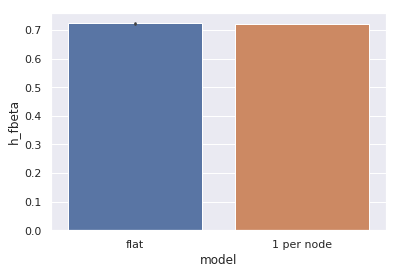

In [10]:
sns.barplot(data=all_results, y="h_fbeta", x="model")#, hue="Ruido %")

In [11]:
for model in ["flat", "1 per node"]:
    model_results = all_results.query("model == @model")
    print(f"For model {model}, we obtained ", 
          f"{model_results.h_fbeta.mean()} h_fbeta +-",
          f"{model_results.h_fbeta.std()}")

For model flat, we obtained  0.7231189304881432 h_fbeta +- 0.003311066039233607
For model 1 per node, we obtained  0.7213053625165888 h_fbeta +- 0.0030069685021306873


TODO: Not done yet

### Binary classifier per Node

In [12]:
def binary_per_node(df, mosquitos_hierarchy, encoding, clf):
    X = df.drop(columns="class")
    y = encoding.transform(df["class"].str.split(".").apply(lambda x: x[-1]))
    y = y.astype(str)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=RANDOM_STATE)
    
    y_preds = np.zeros(len(y_test))
    
    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    target_names = encoding.inverse_transform(np.sort(np.unique(y)).astype(int))
    print("Classification Report:\n", classification_report(y_test, y_pred, 
                                                           target_names=target_names))
    # Demonstrate using our hierarchical metrics module with MLB wrapper
    try:
        my_graph = clf.graph_
    except:
        from networkx import DiGraph
        my_graph = DiGraph(class_hierarchy)
        
    with multi_labeled(y_test, y_pred, my_graph) as (y_test_, y_pred_, graph_):
        results = {
            "h_fbeta": h_fbeta_score(y_test_, y_pred_, graph_),
            "h_precision": h_precision_score(y_test_, y_pred_, graph_),
            "h_recall": h_recall_score(y_test_, y_pred_, graph_),
        }
    return results

## HMC

In [11]:
ch = hmc.ClassHierarchy("ROOT")
options = [x.split(".")[1:] for x in df["class"].unique()]

for class_ in options:
    for previous, current in zip(["ROOT"]+class_, class_):
        ch.add_node(current, previous)
        """
        if current in last_classes:
            class_num = encoding.transform([current])[0]
            mosquitos_hierarchy[previous].add(f"{class_num}")
        else:
            mosquitos_hierarchy[previous].add(current)
        """
ch.print_()

└─ROOT
  ├─Chironomidae
  │ └─Chironomus
  │   └─Cxanthus
  ├─Culicidae
  │ ├─Aedes
  │ │ ├─Aeaegypti
  │ │ │ ├─Aeaegypti:F
  │ │ │ └─Aeaegypti:M
  │ │ └─Aealbopictus
  │ │   ├─Aealbopictus:F
  │ │   └─Aealbopictus:M
  │ ├─Anopheles
  │ │ └─Aaquasalis
  │ │   ├─Aaquasalis:F
  │ │   └─Aaquasalis:M
  │ └─Culex
  │   ├─Cxquinquefasciatus
  │   │ ├─Cxquinquefasciatus:F
  │   │ └─Cxquinquefasciatus:M
  │   └─Cxtarsalis
  │     └─Cxtarsalis:both
  ├─Drosophilidae
  │ └─Drosophila
  │   ├─Dmelanogaster
  │   └─Dsuzukii
  └─Muscidae
    └─Musca
      └─Mdomestica


In [41]:
dth = hmc.DecisionTreeHierarchicalClassifier(ch)
y = pd.DataFrame(df["class"].str.split(".").apply(lambda x: x[-1]), 
                 columns=["label"])
dth = dth.fit(df.drop(columns="class"), y)
dth_predicted = dth.predict(X_test)
dth_accuracy = dth.score(X_test, y_test)

KeyError: range(0, 33)

In [39]:
y = df["class"].str.split(".").apply(lambda x: x[-1])#.unique()
y.unique()

array(['Cxquinquefasciatus:M', 'Aealbopictus:F', 'Aealbopictus:M',
       'Aeaegypti:M', 'Aeaegypti:F', 'Mdomestica', 'Cxquinquefasciatus:F',
       'Dsuzukii', 'Dmelanogaster', 'Aaquasalis:F', 'Cxtarsalis:both',
       'Aaquasalis:M', 'Cxanthus'], dtype=object)

In [42]:
ch = hmc.load_shades_class_hierachy()
X, y = hmc.load_shades_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50)

In [43]:
dth = hmc.DecisionTreeHierarchicalClassifier(ch)
dth = dth.fit(X_train, y_train)
dth_predicted = dth.predict(X_test)
dth_accuracy = dth.score(X_test, y_test)

KeyError: range(0, 3)

In [29]:
X, y = hmc.load_shades_data()

In [33]:
X.shape, y.shape

((1017, 3), (1017, 1))

In [24]:
df["class"].str.split(".").apply(lambda x: x[-1])#.unique()

0        Cxquinquefasciatus:M
1        Cxquinquefasciatus:M
2        Cxquinquefasciatus:M
3        Cxquinquefasciatus:M
4        Cxquinquefasciatus:M
5              Aealbopictus:F
6              Aealbopictus:F
7              Aealbopictus:F
8              Aealbopictus:F
9              Aealbopictus:F
10             Aealbopictus:M
11             Aealbopictus:M
12             Aealbopictus:M
13             Aealbopictus:M
14             Aealbopictus:M
15                Aeaegypti:M
16                Aeaegypti:M
17                Aeaegypti:M
18                Aeaegypti:M
19                Aeaegypti:M
20                Aeaegypti:F
21                Aeaegypti:F
22                Aeaegypti:F
23                Aeaegypti:F
24                Aeaegypti:F
25                 Mdomestica
26                 Mdomestica
27                 Mdomestica
28                 Mdomestica
29                 Mdomestica
                 ...         
21692           Dmelanogaster
21693              Mdomestica
21694     

In [34]:
X.head()

,a,b,c
0,3.904972,4.438867,-0.148988
1,4.676289,4.481424,1.812624
2,0.427846,8.276370,7.482786
3,1.347052,3.815691,2.779839
4,4.342835,10.057471,-0.512811


In [35]:
y.head()

,label
0,dark
1,dark
2,dark
3,dark
4,dark


In [37]:
y["label"].unique()

array(['dark', 'black', 'gray', 'ash', 'slate', 'light', 'white'],
      dtype=object)

In [ ]:
import hmc.metrics as hierarchical_metrics

hierarchical_metrics.accuracy_score(ch, y_test, dth_predicted)
hierarchical_metrics.precision_score_ancestors(ch, y_test, dth_predicted)
hierarchical_metrics.recall_score_ancestors(ch, y_test, dth_predicted)
#metrics.f1_score_descendants(ch, y_test, dth_predicted)
#hierarchical_metrics.f1_score_ancestors(ch, y_test, dth_predicted)
#hierarchical_metrics.precision_score_descendants(ch, y_test, dth_predicted)
#hierarchical_metrics.recall_score_descendants(ch, y_test, dth_predicted)